In [8]:
import retro
import time
import numpy as np
from gym import Env
from gym.spaces import MultiBinary, Box, Discrete
import cv2
from matplotlib import pyplot as plt
import os
import optuna
from stable_baselines3.qrdqn import QRDQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
print(retro.__file__)

ImportError: cannot import name 'quantile_huber_loss' from 'stable_baselines3.common.utils' (c:\Users\TheHeatbringer\Anaconda3\envs\RLProject\lib\site-packages\stable_baselines3\common\utils.py)

In [2]:
!python -m retro.import ./custom_integrations

Importing StreetFighterIISpecialChampionEdition-Genesis
Imported 1 games


In [3]:
LOG_DIR = './logs/QRDQN'
OPT_DIR = './opt/QRDQN'
CHECKPOINT_DIR = './train/QRDQN/'

In [4]:
class StreetFighter(Env):
    def __init__(self,game_state='Champion.Level1.RyuVsGuile.state',record=False):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(2**12)
        self.total_matches_won = 0
        self.total_enemy_matches_won = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        self.record = record
        # if record:
        #     self.game = retro.make(game='StreetFighterII-Champion', record='.',state=game_state,use_restricted_actions=retro.Actions.DISCRETE)
        # else:
        self.game = retro.make(game='StreetFighterII-Champion', state=game_state,use_restricted_actions=retro.Actions.DISCRETE)


    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs_orig = obs
        obs = self.preprocess(obs)
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        if self.prev_matches_won > info['matches_won']:
            self.prev_matches_won = info['matches_won']
        if self.prev_enemy_matches_won > info['enemy_matches_won']:
            self.prev_enemy_matches_won = info['enemy_matches_won']
        self.total_matches_won = self.total_matches_won + info['matches_won'] - self.prev_matches_won
        self.total_enemy_matches_won = self.total_enemy_matches_won + info['enemy_matches_won'] - self.prev_enemy_matches_won
        self.prev_matches_won = info['matches_won']
        self.prev_enemy_matches_won = info['enemy_matches_won']
        reward = info['score'] - self.score
        self.score = info['score']
        self.obs_orig = obs_orig
        return frame_delta, reward, done, info
        
    def get_obs_orig(self):
        return self.obs_orig

    def render(self,*args,**kwargs):
        self.game.render()

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        return obs

    def preprocess(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), cv2.INTER_CUBIC)
        channels = np.reshape(resize, (84,84,1))
        return channels

    def close(self):
        self.game.close()

In [9]:
env = StreetFighter()

TypeError: 'module' object is not callable

In [20]:
obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    if reward != 0:
        # print(reward)
        print(info)
        # print(env.total_matches_won)
        # print(env.total_enemy_matches_won)

    env.render()
    if done:
        break
    action = env.action_space.sample()

print(info)
print(env.total_matches_won)
print(env.total_enemy_matches_won)

obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    if reward != 0:
        # print(reward)
        print(info)
        # print(env.total_matches_won)
        # print(env.total_enemy_matches_won)
    env.render()
    if done:
        break
    action = env.action_space.sample()

print(info)
print(env.total_matches_won)
print(env.total_enemy_matches_won)

env.close()

{'enemy_matches_won': 0, 'score': 500, 'matches_won': 0, 'continuetimer': 0, 'enemy_health': 147, 'health': 176}
{'enemy_matches_won': 0, 'score': 800, 'matches_won': 0, 'continuetimer': 0, 'enemy_health': 119, 'health': 176}
{'enemy_matches_won': 0, 'score': 1800, 'matches_won': 0, 'continuetimer': 0, 'enemy_health': 119, 'health': 176}
{'enemy_matches_won': 0, 'score': 2300, 'matches_won': 0, 'continuetimer': 0, 'enemy_health': 79, 'health': 176}
{'enemy_matches_won': 0, 'score': 2600, 'matches_won': 0, 'continuetimer': 0, 'enemy_health': 32, 'health': 162}
{'enemy_matches_won': 0, 'score': 4100, 'matches_won': 1, 'continuetimer': 0, 'enemy_health': -1, 'health': 162}
{'enemy_matches_won': 0, 'score': 4200, 'matches_won': 1, 'continuetimer': 0, 'enemy_health': -1, 'health': 162}
{'enemy_matches_won': 0, 'score': 4300, 'matches_won': 1, 'continuetimer': 0, 'enemy_health': -1, 'health': 162}
{'enemy_matches_won': 0, 'score': 4400, 'matches_won': 1, 'continuetimer': 0, 'enemy_health': -

In [5]:
def optimize(trial):
    return {
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-5,1e-4),
        'gamma':trial.suggest_loguniform('gamma', 0.8,0.9999),
        'tau':trial.suggest_loguniform('tau', 0.001,0.01),
    }

In [6]:
env.close()

NameError: name 'env' is not defined

In [8]:
env.observation_space

NameError: name 'env' is not defined

In [6]:
def optimize_agent(trial):
        model_params = optimize(trial)
        env = StreetFighter()
        env = Monitor(env,LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env,4,channels_order='last')

        model = QRDQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 

        # model = QRDQN("CnnPolicy",env,gradient_steps=-1,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
        model.learn(total_timesteps=80000, progress_bar=True)

        mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        print(mean_reward)
        
        return mean_reward

In [7]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)

[I 2024-04-20 14:19:44,757] A new study created in memory with name: no-name-9ff7e43f-ac23-4504-862b-d0dde007ea98
c:\Users\TheHeatbringer\Anaconda3\envs\RLProject\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\TheHeatbringer\Anaconda3\envs\RLProject\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
c:\Users\TheHeatbringer\Anaconda3\envs\RLProject\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/QRDQN\QRDQN_14


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.12e+04 |
|    ep_rew_mean      | 3.59e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1297     |
|    time_elapsed     | 34       |
|    total_timesteps  | 44751    |
----------------------------------


In [17]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[37900.0], datetime_start=datetime.datetime(2024, 4, 19, 13, 51, 42, 69181), datetime_complete=datetime.datetime(2024, 4, 19, 15, 19, 26, 203656), params={'learning_rate': 4.040860237684753e-05, 'gamma': 0.9188515077605203, 'tau': 0.004185543615675516}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'tau': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, trial_id=0, value=None)

In [18]:
study.best_params

{'learning_rate': 4.040860237684753e-05,
 'gamma': 0.9188515077605203,
 'tau': 0.004185543615675516}

In [19]:
model = QRDQN.load(os.path.join(OPT_DIR, 'trial_0_best_model'))

In [23]:
env = StreetFighter()
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [24]:
# model = QRDQN.load(os.path.join(OPT_DIR, 'trial_0_best_model'))
# 
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)
# reward is 37900
print(mean_reward)

c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


37900.0


In [25]:
mean_reward, _ = evaluate_policy(model, env, render=False, n_eval_episodes=5)
print(mean_reward)

37900.0


In [8]:
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}_'.format(self.n_calls))
            self.model.save(model_path)
            self.logger.record('matches_won', self.training_env.get_attr('total_matches_won')[0])
            self.logger.record('enemy_matches_won', self.training_env.get_attr('total_enemy_matches_won')[0])

        return True

In [15]:
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [37]:
env.close()

In [11]:
env = StreetFighter()
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [16]:
model_params = {}
model_params['learning_rate'] = 4.040860237684753e-05
model_params['gamma'] = 0.9188515077605203
model_params['tau'] = 0.004185543615675516

In [17]:
model = QRDQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
# model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))
model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))
model.learn(total_timesteps=1000000,callback=callback)
# can increase training time and learning rate later

Using cpu device
Wrapping the env in a VecTransposeImage.


c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.52GB > 4.00GB
  "This system does not have apparently enough memory to store the complete "


Logging to ./logs/QRDQN\QRDQN_1


KeyboardInterrupt: 

In [18]:
model = QRDQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_180000_'))
# 1050000, 180000
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=5)
print(mean_reward)
# mean of opt/trial model is 43000
# mean of best 1050000 is 30400
# mean of best 180000 is 5600



5600.0


In [19]:
obs = env.reset()
env.step(model.predict(obs)[0])

(array([[[[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          ...,
          [  0,   0,  37,   0],
          [  0,   0,  34,   0],
          [  0,   0,  36,   0]],
 
         [[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          ...,
          [  0,   0,  36,   0],
          [  0,   0,  39,   0],
          [  0,   0,  40,   0]],
 
         [[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          ...,
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0]],
 
         ...,
 
         [[  0,   0, 162,   0],
          [  0,   0, 162,   0],
          [  0,   0, 162,   0],
          ...,
          [  0,   0, 162,   0],
          [  0,   0, 162,   0],
          [  0,   0, 162,   0]],
 
         [[  0,   0, 162,   0],
          [  0,   0, 162,   0],
          [  0,   0, 162,   0],
          ...,
          [  0,   0, 162,   0],
 

In [13]:
env.close()

In [6]:
from matplotlib import animation
import matplotlib.pyplot as plt

In [7]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=180)

c:\Users\reece\anaconda3\envs\streetfighter37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
MovieWriter imagemagick unavailable; using Pillow instead.


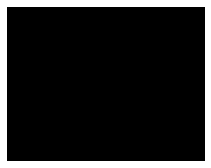

: 

In [8]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""

#Make gym env
my_env = StreetFighter()
env = Monitor(my_env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_1050000_'))
obs = env.reset()
done = False
frames = []

while not done:
    if done:
        break
    # frames.append(env.render(mode="rgb_array"))
    env.render()
    obs,reward,done,info = env.step(model.predict(obs)[0])
    rec_obs = my_env.get_obs_orig()
    frames.append(rec_obs)
env.close()

save_frames_as_gif(frames)

In [24]:
print(frames)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [20]:
env = StreetFighter(record=True)
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_1050000_'))
obs = env.reset()
done = False

while not done:
    if done:
        break
    env.render()
    obs,reward,done,info = env.step(model.predict(obs)[0])
env.close()

RuntimeError: Cannot create multiple emulator instances per process, make sure to call env.close() on each environment before creating a new one

In [13]:
env.close()

In [14]:
movie = retro.Movie('./StreetFighterII-Champion-Champion.Level1.RyuVsGuile-000000.bk2')
movie.step()

env = retro.make(
    game=movie.get_game(),
    state=None,
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
env.reset()

while movie.step():
    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i,p))
        env.step(keys)
    env.render()

In [15]:
env.close()

In [7]:
import gym

In [8]:
env.close()

In [17]:
import retro

In [19]:
!python3 -m retro.scripts.playback_movie ./StreetFighterII-Champion-Champion.Level1.RyuVsGuile-000000.bk2

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\reece\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\retro\scripts\playback_movie.py", line 213, in _play
    emulator, m, duration = load_movie(movie)
  File "C:\Users\reece\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\retro\scripts\playback_movie.py", line 181, in load_movie
    movie = retro.Movie(movie_file)
RuntimeError: Could not load movie

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\concurrent\futures\process.py", line 239, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Pyth

better at dodging attacks, doesn't know what to do for less common scenarios, ie confused
instead of dodging sonic boom, will attack with hadoken (to gain reward)